# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

sns.set_style("whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


Load Data

In [ ]:

      # We pass pandas arguments here to handle the messy CSV format immediately
      pandas_kwargs={
          "names": ['Timestamp', 'CAN_ID', 'DLC', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Flag'],
          "header": None
      }


    print(f"Successfully loaded {target_file}")
    print(f"Dataset Shape: {df.shape}")

    # Drop Timestamp immediately as per our cleaning strategy
    if 'Timestamp' in df.columns:
        df = df.drop(columns=['Timestamp'])

    # Fill NaNs (important for this dataset structure)
    df.fillna(0, inplace=True)

    print("Initial cleanup complete.")
    display(df.head())

except Exception as e:
    print(f"Failed to load data: {e}")

/tmp/ipython-input-1892163107.py:18: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 181M/181M [00:13<00:00, 14.4MB/s]


Successfully loaded DoS_dataset.csv
Dataset Shape: (3665771, 12)
Initial cleanup complete.


,CAN_ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Flag
0,0316,8,05,21,68,09,21,21,00,6f,R
1,018f,8,fe,5b,00,00,00,3c,00,00,R
2,0260,8,19,21,22,30,08,8e,6d,3a,R
3,02a0,8,64,00,9a,1d,97,02,bd,00,R
4,0329,8,40,bb,7f,14,11,20,00,14,R


# Preprocessing

In [ ]:

def hex_to_int(val):
    try:
        if isinstance(val, str):
            return int(val, 16)
        return int(val)
    except:
        return 0

print("Processing CAN IDs...")
df['CAN_ID'] = df['CAN_ID'].astype(str).apply(hex_to_int)

print("Processing Data Bytes...")
data_cols = [f'Data{i}' for i in range(8)]
for col in data_cols:
    df[col] = df[col].astype(str).apply(hex_to_int)


print("Encoding Target Labels...")
df['Target'] = df['Flag'].map({'R': 0, 'T': 1})

df = df.dropna(subset=['Target'])

X = df[['CAN_ID'] + data_cols]
y = df['Target']

print(f"Preprocessing complete. Features shape: {X.shape}")

Processing CAN IDs...
Processing Data Bytes...
Encoding Target Labels...
Preprocessing complete. Features shape: (3634583, 9)


# Train/Test Split

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 2907666
Testing set size: 726917


# Model Training

In [ ]:

from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest Classifier... (This may take a moment)")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Model trained successfully.")

Training Random Forest Classifier... (This may take a moment)
Model trained successfully.


# Evaluation


Model Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Normal (R)       1.00      1.00      1.00    609413
  Attack (T)       1.00      1.00      1.00    117504

    accuracy                           1.00    726917
   macro avg       1.00      1.00      1.00    726917
weighted avg       1.00      1.00      1.00    726917



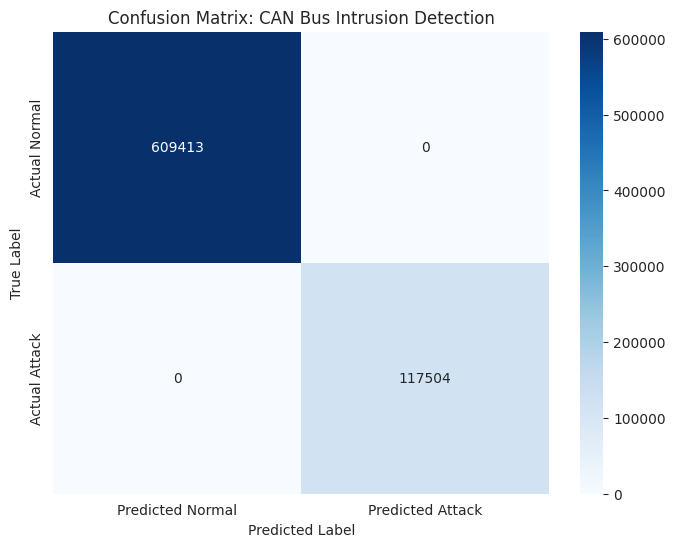

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal (R)', 'Attack (T)']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.title('Confusion Matrix: CAN Bus Intrusion Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance

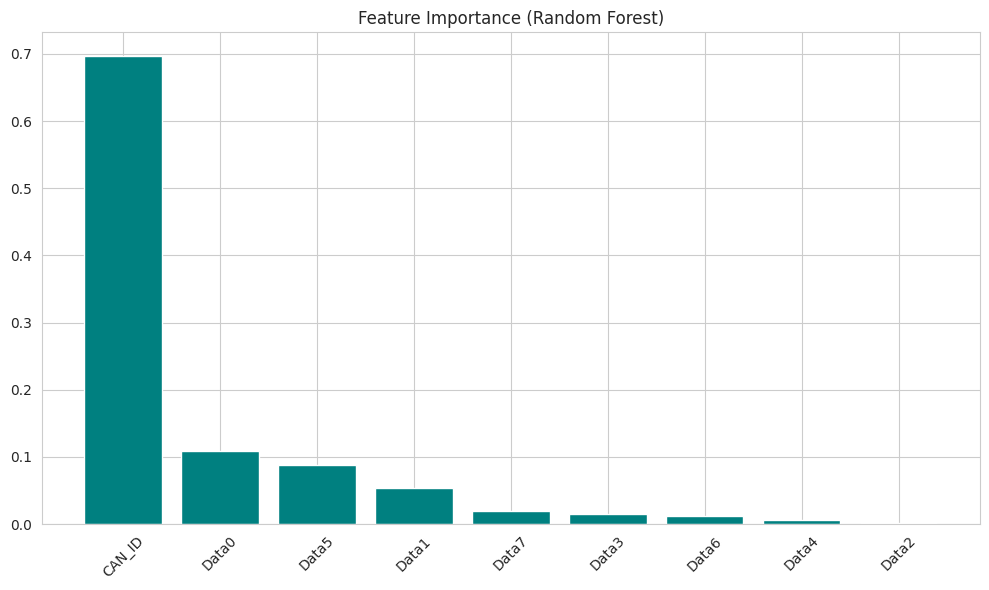

In [ ]:

import numpy as np

importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()

# Sample Predictions

In [ ]:

import pandas as pd

print("\n--- Sample Real-time Predictions ---")
sample_data = X_test.sample(5)
sample_preds = rf_model.predict(sample_data)
sample_actuals = y_test.loc[sample_data.index]

results = pd.DataFrame({
    'CAN_ID': sample_data['CAN_ID'],
    'Data0': sample_data['Data0'],
    'Prediction': ['Attack' if p==1 else 'Normal' for p in sample_preds],
    'Actual': ['Attack' if a==1 else 'Normal' for a in sample_actuals]
})

display(results)


--- Sample Real-time Predictions ---


,CAN_ID,Data0,Prediction,Actual
609217,704,20,Normal,Normal
1377006,672,4,Normal,Normal
59547,1201,41,Normal,Normal
1462866,672,36,Normal,Normal
3357133,1201,41,Normal,Normal
